# SVM-Based Pairs Trading Alogritm

The premise of this project is to design and train a Support Vector Machine model to pairs trade a mean-reverting set of securities, and identify profitable long/short portfolios. 

Pairs trading is a classic trading approach used by hedge funds due to it's built in risk management features. The core premise is to find a pair of assets that are both economically connected and statistically cointegrated. This allows us to trade a linear pair of these assets in opposing directions, profitting as this pair returns to the mean. 

For this project, we will be exploring the sector indeces of the SP500 - an index containing the top 500 stocks in the US weighted by market capitalization. 

The structure of this project is to:
1. Find Co-Integrated pairs
2. Construct and train an SVM to monitor said pair, classifying a 1 if the spread grows, 0 if the spread shrinks
3. Backtest this algorithm and evaluate profitability and Sharpe

## Set up

In [103]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
# Data is imported based on the import file import_data.py
# Below is a list of sectors to examine 

sector_indices = [
    "SPY",  # S&P 500 ETF as a placeholder
    "XLY",  # Consumer Discretionary
    "XLP",  # Consumer Staples
    "XLE",  # Energy
    "XLF",  # Financials
    "XLV",  # Health Care
    "XLI",  # Industrials
    "XLK",  # Information Technology
    "XLB",  # Materials
    "XLRE"  # Real Estate
]

In [11]:
# Reading in data
data_path = "./sector_data/"
sector_dfs = {i: pd.read_csv(f"{data_path}{i}_historical.csv", index_col=['date']) for i in sector_indices}

In [95]:
'''

This cell combines all relevant sector indices into one larger dataframe. We only care about the VWAP (Volume weighted average trade price) fro our analysis, because while it does not neccesarily represent a tradeable price, 
it allows us to extract the "true cost" of an asset over the day, and avoids any idiosincratic peaks or valleys in market open or market close trading activity. 

'''

# Initialize df as an empty DataFrame
df = pd.DataFrame()

# Loop through the items in sector_dfs
for i, sec_df in sector_dfs.items():
    # If df is empty, initialize it with the 'vwap' column
    if df.empty:
        df = sec_df[["vwap"]].copy()  # Use .copy() to avoid potential SettingWithCopyWarning
        df.rename(columns={"vwap": i}, inplace=True)  # Rename 'vwap' column to the sector name
    else:
        # Add the 'vwap' column from sec_df to df with the sector name as the column label
        df = pd.concat([df, sec_df[["vwap"]].rename(columns={"vwap": i})], axis=1)

df.index = pd.to_datetime(df.index)

df.head()

,SPY,XLY,XLP,XLE,XLF,XLV,XLI,XLK,XLB,XLRE
date,,,,,,,,,,
2024-11-15,586.2500,213.4800,80.3000,94.920,49.7800,142.5100,139.310,229.4300,91.4600,42.8600
2024-11-14,595.2825,216.8250,80.7725,94.865,49.7650,145.5125,141.000,235.1275,92.2350,43.0775
2024-11-13,597.1875,218.2875,80.7150,94.100,49.8575,147.0675,142.375,235.6625,92.5775,43.4200
2024-11-12,597.3100,217.5275,80.7275,94.215,49.7850,148.1950,142.635,235.6450,93.0050,43.2375
2024-11-11,598.9350,218.9650,80.7950,93.995,49.8450,149.7075,143.165,236.1750,94.2875,43.7325


In [96]:
'''

Here we are taking a quick look at the length of the timeseries, before running a test train split to seperate our data

'''
df = df.sort_index(ascending=True)

# Examining Time Series before split
print(f"Total time is {df.index.max() - df.index.min()} from {df.index.min()} to {df.index.max()}")

# Calculate the index for the last 20%
split_index = int(len(df) * 0.8)  # First 80%

# Split the DataFrame
train_df = df.iloc[:split_index]  # First 80%
test_df = df.iloc[split_index:]   # Last 20%

print(f"Total train time is {train_df.index.max() - train_df.index.min()} from {train_df.index.min()} to {train_df.index.max()}")
print(f"Total test time is {test_df.index.max() - test_df.index.min()} from {test_df.index.min()} to {test_df.index.max()}")

Total time is 1824 days 00:00:00 from 2019-11-18 00:00:00 to 2024-11-15 00:00:00
Total train time is 1458 days 00:00:00 from 2019-11-18 00:00:00 to 2023-11-15 00:00:00
Total test time is 365 days 00:00:00 from 2023-11-16 00:00:00 to 2024-11-15 00:00:00


In [97]:
df.head()

,SPY,XLY,XLP,XLE,XLF,XLV,XLI,XLK,XLB,XLRE
date,,,,,,,,,,
2019-11-18,311.715,121.5100,61.5450,59.4800,29.7600,97.3600,82.0375,87.305,60.1875,38.7150
2019-11-19,312.130,120.8475,61.6475,58.8100,29.8775,97.6025,82.0675,87.700,60.2250,38.8225
2019-11-20,310.740,120.3800,61.6450,58.7725,29.7025,97.5850,81.4425,87.205,59.6000,38.8075
2019-11-21,310.390,119.9225,61.5025,59.6100,29.7325,97.6650,81.2625,86.815,59.2550,38.5425
2019-11-22,310.785,120.0850,61.3250,59.9975,29.8375,98.1525,81.5000,86.720,59.3875,38.2100


## Co-Integration Testing and Pair Identification

In [98]:
'''

Here, we are running the Engle-Granger co-integration test, to see if we can extract a stationary time series from two series of asset prices. We will only want to trade pairs where we are confident of co-integration
beyond 98% certainty (p-value < 0.02)

'''

stocks = sector_indices
coint_pairs = {}

for i in range(len(stocks)):
    for j in range(i+1, len(stocks)):
        x = train_df[stocks[i]]
        y = train_df[stocks[j]]
        # Perform the Engle-Granger test
        score, p_value, critical_values = coint(y, x)

        if p_value < 0.02:
            # Display results
            print(stocks[i], stocks[j])
            print("Cointegration Test Score:", score)
            print("p-value:", p_value)
            print("Critical Values:", critical_values)
            print("The series are cointegrated.")
            coint_pairs[(stocks[i], stocks[j])] = p_value

XLP XLV
Cointegration Test Score: -3.7434430828933283
p-value: 0.016097512007508377
Critical Values: [-3.90737061 -3.34221646 -3.04867279]
The series are cointegrated.


{('XLP', 'XLV'): 0.016097512007508377}


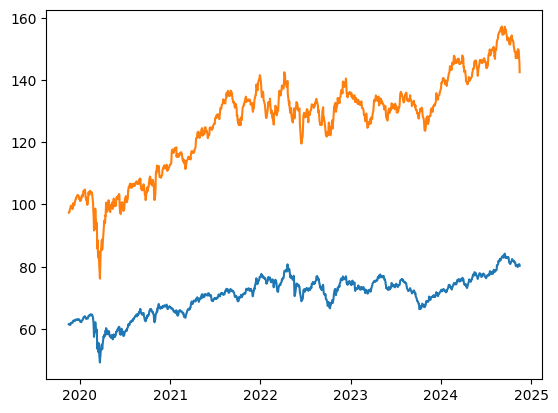

In [106]:
'''

Here we can see that one pair matches our criteria, the S&P Consumer Staples and Healthcare secotrs. This seems to make sense, as both consumer staples and 
healthcare are well insulated from market shocks, and thus are not subject to the same economic cycles as a wide variety of other sector indeces. Rather, 
they are exposed to a few, major economic factors but have stable demand for the sector's goods regardless of economic climate.  

'''
print(coint_pairs)
plt.plot(df[['XLP', 'XLV']])


### For the context of this project, I will now limit this study to only one co-integrated pair. However, this can easily be extended by creating multiple models for each pair of assets one wishes to trade

## Feature Generation

In [100]:
tradeable_assets = list(coint_pairs.keys())[0]
asset1 = tradeable_assets[0]
asset2 = tradeable_assets[1]

In [101]:
def calculate_hedge_ratio(stock1, stock2):
    """
    Calculates the hedge ratio between two stocks using OLS regression.
    
    Parameters:
        stock1: Series of prices for the first stock.
        stock2: Series of prices for the second stock.
        
    Returns:
        hedge_ratio: The hedge ratio (beta) between the two stocks.
    """
    # Add a constant to the independent variable (stock2)
    stock2_with_const = sm.add_constant(stock2)
    
    # Perform OLS regression
    model = sm.OLS(stock1, stock2_with_const).fit()
    
    # Hedge ratio is the slope of the regression line
    hedge_ratio = model.params.iloc[1]
    return hedge_ratio

<Axes: xlabel='date'>

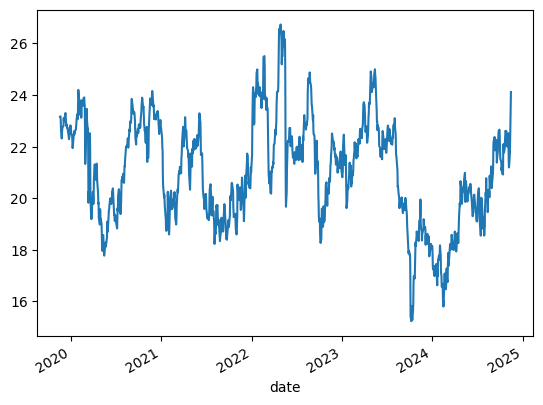

In [102]:
'''

The hedge ratio represents the ratio with which the series becomes co-integrated. The stationary series should be y(t) = x_1(t) + b(x_2(t))

'''

hedge_ratio = calculate_hedge_ratio(train_df[asset1], train_df[asset2])
(df[asset1] - hedge_ratio*df[asset2]).plot()

In [202]:
hedge_ratio

0.39423664753972604

Relevant Note: For the purpose of this study, we assume that the co-integration/hedge ratio stays constant over time. This is not a valid assumption to make in real financial markets. To adapt this, the co-integration test would need to be run consistently, and when the pair is broken trading should be halted. 

In [108]:
train_df = train_df[list(tradeable_assets)]
test_df = test_df[list(tradeable_assets)]

In [132]:
features_df = pd.DataFrame(pd.concat([train_df, test_df]))
features_df

,XLP,XLV
date,,
2019-11-18,61.5450,97.3600
2019-11-19,61.6475,97.6025
2019-11-20,61.6450,97.5850
2019-11-21,61.5025,97.6650
2019-11-22,61.3250,98.1525
...,...,...
2024-11-11,80.7950,149.7075
2024-11-12,80.7275,148.1950
2024-11-13,80.7150,147.0675


In [133]:
# This variable calculates the spread of our asset, according to the co-integrated linear combination
features_df["spread"] = features_df[asset1] - hedge_ratio*features_df[asset2]

In [134]:
# These metrics add information about price ratios, with a log transformation to capture non-linear relationships
features_df["log_price_spread"] = np.log(features_df[asset1]) - np.log(features_df[asset2])
features_df["price_ratio"] = features_df[asset1] / features_df[asset2]

In [135]:
# This captures the rolling correlation of the two assets, which may be usefull in determining the growth/shrinking of the spread
features_df["rolling_corr"] = features_df[asset1].rolling(window=30).corr(features_df[asset2])

In [136]:
# These features capture aditional information about the spread over time, which may be helpful as lagged prediction features. 
features_df["rolling_spread_mean"] = features_df["spread"].rolling(window=30).mean()
features_df["rolling_spread_std"] = features_df["spread"].rolling(window=30).std()

In [139]:
# Given all of our rolling variables have 30 day windows, I am dropping the first 30 days of data due to NanS
features_df = features_df.iloc[30:]

In [152]:
features_df.loc[:, "target"] = (abs(features_df["spread"].shift(-1)) > abs(features_df["spread"])).astype(int)
features_df = features_df.dropna()

In [169]:
features_df

,XLP,XLV,spread,log_price_spread,price_ratio,rolling_corr,rolling_spread_mean,rolling_spread_std,target
date,,,,,,,,,
2020-01-02,62.7475,101.9975,22.536348,-0.485830,0.615187,0.909785,22.808403,0.287972,0.0
2020-01-03,62.3425,101.1150,22.479261,-0.483615,0.616550,0.899707,22.785411,0.285714,0.0
2020-01-06,62.3925,101.3250,22.446472,-0.484888,0.615766,0.887637,22.761179,0.282480,0.0
2020-01-07,62.1775,101.5300,22.150653,-0.490361,0.612405,0.852357,22.732889,0.299773,0.0
2020-01-08,62.2050,102.1300,21.941611,-0.495811,0.609077,0.791340,22.709953,0.332479,1.0
...,...,...,...,...,...,...,...,...,...
2024-11-11,80.7950,149.7075,21.774817,-0.616768,0.539686,0.799157,21.844006,0.535066,1.0
2024-11-12,80.7275,148.1950,22.303600,-0.607450,0.544738,0.790681,21.844387,0.535401,1.0
2024-11-13,80.7150,147.0675,22.735602,-0.599967,0.548830,0.778370,21.869371,0.559200,1.0


## Model Selection and Training

In [153]:
from pycaret.classification import *

In [197]:
# Initializing PyCaret Experiment
model = setup(
    
    # Basic options
    data = features_df,
    target = "target",
    train_size = 0.8,
    fold_strategy='timeseries',
    data_split_shuffle=False,
    fold_shuffle= False,
    data_split_stratify=False,

    preprocess=True,

    # Feature normalization
    normalize = True,
    normalize_method = 'zscore',
    
    # Dealing with collinearity
    remove_multicollinearity = True,
    multicollinearity_threshold = 0.7,
    
    # Paralellization options
    n_jobs = - 1,
    use_gpu = True,

    # MLFlow experiments registry
    log_experiment = True,
    experiment_name = "spread_classifier",
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1


[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,6139
1,Target,target
2,Target type,Binary
3,Original data shape,"(1228, 9)"
4,Transformed data shape,"(1228, 6)"
5,Transformed train set shape,"(982, 6)"
6,Transformed test set shape,"(246, 6)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


In [198]:
# Comparing Models
models = compare_models(sort="Accuracy", fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.5264,0.5301,0.5600,0.5011,0.5247,0.0588,0.0609,0.0260
et,Extra Trees Classifier,0.5264,0.5449,0.3539,0.5406,0.3798,0.0500,0.0642,0.0900
svm,SVM - Linear Kernel,0.5239,0.5159,0.4658,0.4269,0.4120,0.0139,0.0028,0.0240
lightgbm,Light Gradient Boosting Machine,0.5227,0.5411,0.5543,0.5125,0.5018,0.0605,0.0711,0.0700
rf,Random Forest Classifier,0.5202,0.5211,0.3206,0.4817,0.3532,0.0332,0.0318,0.1000
qda,Quadratic Discriminant Analysis,0.5153,0.5152,0.5096,0.3960,0.4294,0.0409,0.0556,0.0240
dummy,Dummy Classifier,0.5129,0.5000,0.2000,0.0933,0.1272,0.0000,0.0000,0.0200
lda,Linear Discriminant Analysis,0.5080,0.5091,0.5992,0.3887,0.4646,0.0349,0.0228,0.0220
ridge,Ridge Classifier,0.5067,0.5094,0.5916,0.3882,0.4619,0.0322,0.0184,0.0240
lr,Logistic Regression,0.5031,0.5110,0.5815,0.3857,0.4570,0.0246,0.0092,0.0260


/home/nilesh/.local/lib/python3.10/site-packages/pycaret/internal/pycaret_experiment/supervised_experiment.py:323: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  master_display_.apply(
2024/11/17 16:37:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 16:37:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 16:37:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 16:37:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [199]:
clf = create_model("et", fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4831,0.4661,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.5393,0.6184,0.7750,0.4921,0.6019,0.1158,0.1334
2,0.5169,0.5278,0.3673,0.6000,0.4557,0.0645,0.0709
3,0.4831,0.4997,0.7442,0.4776,0.5818,-0.0164,-0.0193
4,0.4607,0.5248,0.3488,0.4286,0.3846,-0.0865,-0.0879
5,0.5730,0.5182,0.7045,0.5536,0.6200,0.1485,0.1542
6,0.5730,0.6036,0.4103,0.5161,0.4571,0.1128,0.1148
7,0.4382,0.4323,0.2000,0.3913,0.2647,-0.1175,-0.1350
8,0.6180,0.5554,0.3000,0.6667,0.4138,0.1870,0.2199


2024/11/17 16:37:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [200]:
tuned_model = tune_model(clf, optimize="Accuracy")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4831,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.5506,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.4494,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.5169,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.5169,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.5056,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.5618,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.4944,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.5506,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


2024/11/17 16:37:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [203]:
import joblib as jb
jb.dump(tuned_model, "spread_model.pkl")

['spread_model.pkl']

In [211]:
temp = features_df[["XLP", "XLV"]].iloc[-29:]

,XLP,XLV
date,,
2024-10-08 00:00:00,80.8450,151.6075
2024-10-09 00:00:00,81.3375,152.5750
2024-10-10 00:00:00,81.3525,152.9925
2024-10-11 00:00:00,81.4850,153.5600
2024-10-14 00:00:00,81.7625,154.3350
2024-10-15 00:00:00,82.4600,153.1550
2024-10-16 00:00:00,82.3000,152.9450
2024-10-17 00:00:00,82.2725,152.6175
2024-10-18 00:00:00,82.0075,152.7975
